In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from SDE_schemes import *
from models import *

# Solving SDEs

In [2]:
def show_method_result(solver: SDESolver, sde: SDE, r0: float, t0: float, tn: float, N: int, options = ''):
    t, x = solver.performSimulation(sde, r0, t0, tn, N)
    plt.plot(t, x, options)

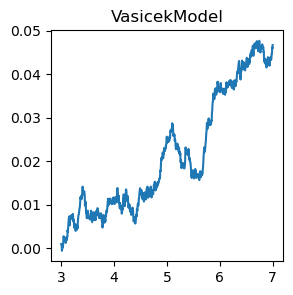

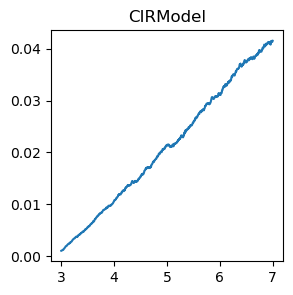

In [3]:
t0 = 3
T = 7
N = 1000
r0 = 0.001

models = [ VasicekModel(0.01, 0.01, 0.01), CIRModel(0.01, 0.01, 0.01)]

for model in models:
    plt.figure(figsize=(3, 3))
    plt.title(type(model).__name__)
    show_method_result(MilsteinSolver, model.getSDE(), r0, t0, T, N)
    plt.show()

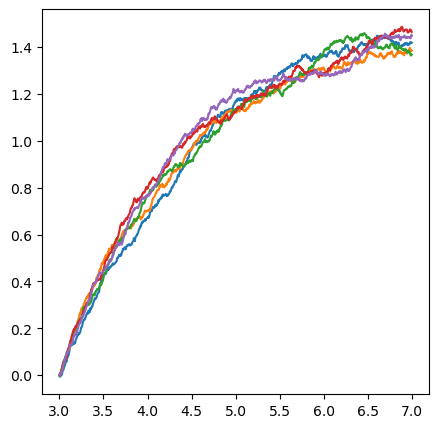

In [4]:
# test wikipedia
t0 = 3
T = 7
N = 1000

def a(x, t):
    return 0.7 * (1.5 - x)

def b(x, t):
    return 0.06

sde = SDE(a, b)

plt.figure(figsize=(5, 5))
for i in range(5):
    show_method_result(MilsteinSolver, sde, 0, t0, T, N)

plt.show()


# Calibration

## data

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/wrcarpenter/Interest-Rate-Models/refs/heads/main/Data/zcbs.csv')
df['Date'] = df['Date'].apply(pd.to_datetime)

df = df.sort_values(by='Date')
df = df.reset_index(drop=True)

df['DaysFromFirst'] = (df['Date'] - df['Date'][0]).dt.days

df

,Date,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,360,DaysFromFirst
0,2022-10-19,0.997245,0.994006,0.990406,0.986556,0.982548,0.978464,0.974368,0.970310,0.966327,...,0.298604,0.299035,0.299500,0.299999,0.300533,0.301102,0.301705,0.302344,0.303019,0
1,2022-10-20,0.997021,0.993684,0.990071,0.986255,0.982302,0.978266,0.974198,0.970136,0.966113,...,0.291312,0.291720,0.292161,0.292635,0.293144,0.293686,0.294262,0.294874,0.295520,1
2,2022-10-21,0.997046,0.993735,0.990152,0.986373,0.982465,0.978485,0.974483,0.970497,0.966558,...,0.281259,0.281669,0.282112,0.282589,0.283099,0.283642,0.284220,0.284833,0.285480,2
3,2022-10-24,0.997029,0.993663,0.989999,0.986125,0.982120,0.978049,0.973971,0.969933,0.965970,...,0.274764,0.275096,0.275459,0.275854,0.276280,0.276738,0.277229,0.277753,0.278309,5
4,2022-10-25,0.997038,0.993689,0.990047,0.986196,0.982210,0.978154,0.974085,0.970049,0.966084,...,0.285780,0.286166,0.286584,0.287036,0.287521,0.288040,0.288593,0.289180,0.289802,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2024-03-04,0.995419,0.990835,0.986293,0.981831,0.977476,0.973250,0.969166,0.965231,0.961443,...,0.277085,0.276992,0.276922,0.276875,0.276851,0.276850,0.276872,0.276918,0.276988,502
343,2024-03-05,0.995427,0.990853,0.986323,0.981875,0.977538,0.973335,0.969279,0.965378,0.961630,...,0.284197,0.284155,0.284136,0.284142,0.284173,0.284229,0.284309,0.284415,0.284546,503
344,2024-03-06,0.995427,0.990855,0.986328,0.981883,0.977546,0.973341,0.969279,0.965368,0.961607,...,0.287331,0.287195,0.287082,0.286991,0.286921,0.286874,0.286849,0.286847,0.286868,504
345,2024-03-07,0.995419,0.990846,0.986324,0.981889,0.977566,0.973378,0.969336,0.965446,0.961708,...,0.285241,0.285091,0.284964,0.284859,0.284776,0.284716,0.284678,0.284663,0.284672,505


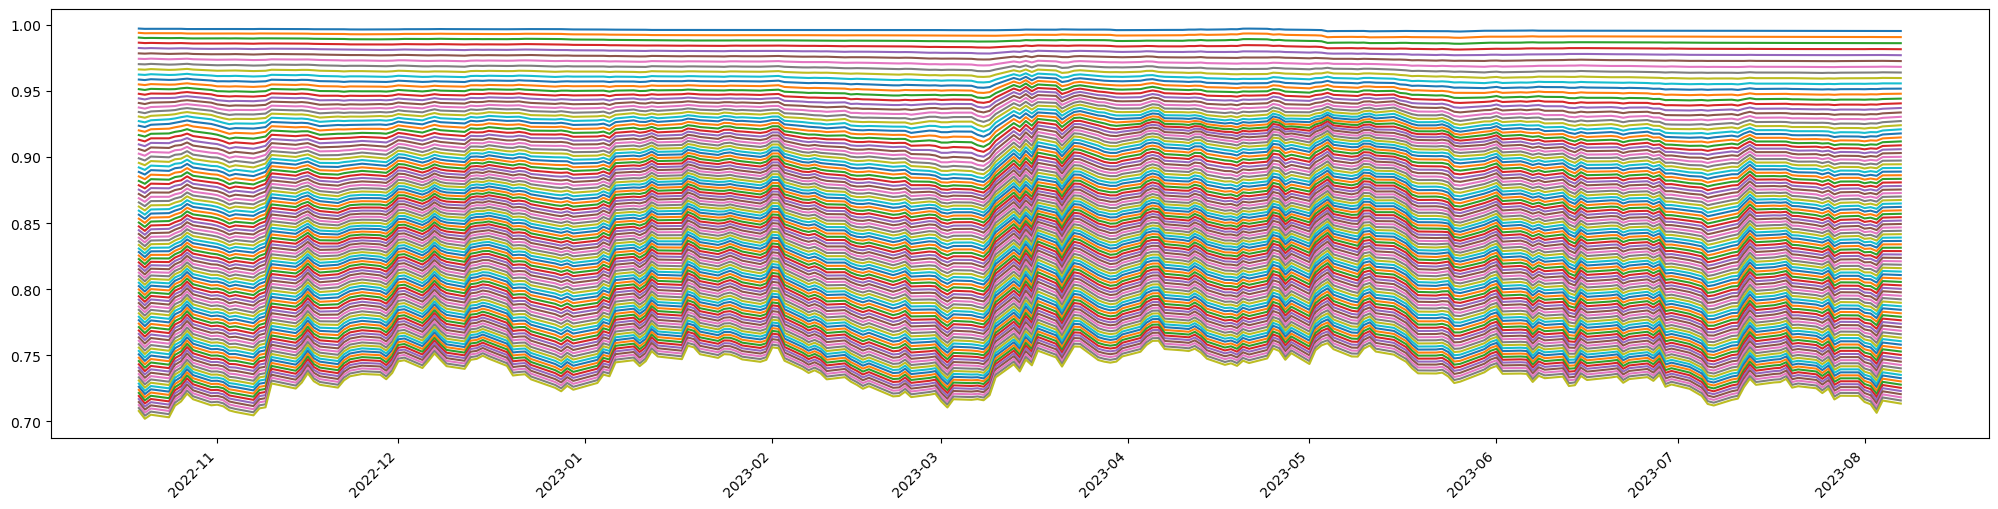

In [6]:
N = 200
dates = df['Date'][:N]

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for i in range(1, 100):
    columnData = df[str(i)][:N]
    plt.plot(dates, columnData, label=f'{i} days')

plt.show()

## calibrating models

0.0036726754061670703 0.0038215666460313094 0.0026418701999976345


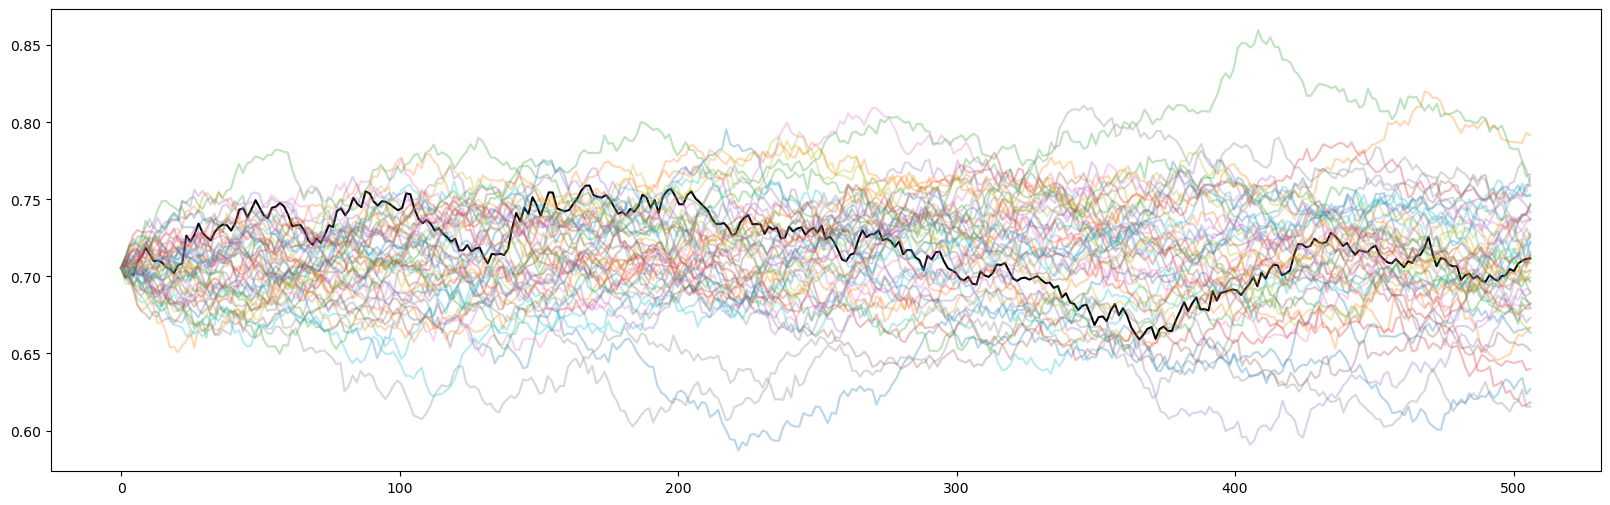

In [7]:
N = df.shape[0]

dates = df['Date']
days = df['DaysFromFirst']

t0 = days.iloc[0]
T = days.iloc[N-1]
dt = (T - t0) / N

model = VasicekModel()
alphaSum = 0.
sigmaSum = 0.
thetaSum = 0.
x0Sum = 0.

plt.figure(figsize=(20, 6))

indexes = [100]
M = len(indexes)
for i in indexes:
    data = df[str(i)][:N]
    model.calibrate(data, dt)
    r0 = data.iloc[0]

    alphaSum += model.alpha
    sigmaSum += model.sigma
    thetaSum += model.theta
    x0Sum += r0
    
    plt.plot(np.linspace(t0, T, N), data, 'k')

model.alpha = alphaSum / M
model.sigma = sigmaSum / M
model.theta = thetaSum / M
r0 = x0Sum / M

print(model.alpha, model.sigma, model.theta)

num_of_simulations = 50
for i in range(num_of_simulations):
    t, x = MilsteinSolver.performSimulation(model.getSDE(), r0, t0, T, N)
    plt.plot(t, x, alpha=0.3)

plt.show()